In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline


In [2]:
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   
session = tf.Session(config=config)
KTF.set_session(session)

Using TensorFlow backend.


In [3]:
import keras 
from models.psenet import psenet

In [4]:
shape = (None,None,3)

In [5]:
inputs = keras.layers.Input(shape=shape)
output = psenet(inputs)
model  = keras.models.Model(inputs,output)
model.summary()

C:\Program Files\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           lambda_1[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]           

In [6]:
from keras.optimizers import Adam
from models.loss import build_loss
from models.metrics import build_iou,mean_iou
from keras.utils import multi_gpu_model

In [7]:
parallel_model = multi_gpu_model(model)

(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)


In [8]:
adam = Adam(1e-3)

In [9]:
ious = build_iou([0,1],['bk','txt'])

In [10]:
parallel_model.compile(loss=build_loss,
              optimizer=adam,
              metrics=ious)

In [11]:
import config 
from tool.generator import Generator

In [12]:
train_dir = config.MIWI_2018_TRAIN_LABEL_DIR
test_dir = config.MIWI_2018_TEST_LABEL_DIR
batch_size = 4
num_class =2 
shape = (640,640)

In [19]:
gen_train = Generator(train_dir,batch_size = batch_size ,istraining=True,num_classes=num_class,reshape=shape)

In [20]:
gen_test = Generator(test_dir,batch_size = batch_size ,istraining=False,num_classes=num_class,reshape=shape,mirror=False,scale=False,clip=False)

In [23]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
checkpoint = ModelCheckpoint(r'resent50-{epoch:02d}.hdf5',
                           save_weights_only=True)
tb = TensorBoard(log_dir='./logs', update_freq=10)

In [25]:
res = parallel_model.fit_generator(gen_train,
                          steps_per_epoch =gen_train.num_samples()// batch_size,
                          epochs = 50,
                          validation_data=gen_test,
                          validation_steps =gen_test.num_samples()//batch_size,
                          verbose=1,
                          initial_epoch=27,
                          workers=4,
                          max_queue_size=16,
                          callbacks=[checkpoint,tb])

Epoch 28/50
 875/2227 [==========>...................] - ETA: 18:47 - loss: 0.1396 - iou_bk: 0.9534 - iou_txt: 0.7719

KeyboardInterrupt: 

In [28]:
parallel_model.optimizer = Adam(1e-4)
res = parallel_model.fit_generator(gen_train,
                          steps_per_epoch =gen_train.num_samples()// batch_size,
                          epochs = 100,
                          validation_data=gen_test,
                          validation_steps =gen_test.num_samples()//batch_size,
                          verbose=1,
                          initial_epoch=50,
                          workers=4,
                          max_queue_size=16,
                          callbacks=[checkpoint,tb])

Epoch 51/100
 185/2227 [=>............................] - ETA: 29:42 - loss: 0.1334 - iou_bk: 0.9549 - iou_txt: 0.7799

KeyboardInterrupt: 

In [29]:
#model.load_weights('resent50-29.hdf5')
parallel_model.save_weights('resnet50-29.hdf5')

In [7]:
images,lables = next(gen_test)

NameError: name 'gen_test' is not defined

In [53]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import os
import tqdm
#dir = r'C:\jianweidata\ocr\psenet\Extraction Test\2x'
dir = r'E:\psenet-MTWI\document\mtwi_2018_task2_test\icpr_mtwi_task2\image_test'
imagesfile = glob.glob(os.path.join(dir,'*.jpg'))
MIN_LEN = 640
MAX_LEN = 1024

In [71]:
from tool.utils import ufunc_4 , scale_expand_kernels ,fit_minarearectange,fit_boundingRect,save_MTWI_2108_resault
with tqdm.tqdm(total = len(imagesfile)) as bar:
    for i,j in enumerate(imagesfile):
                bar.update()
                #j = r'E:\psenet-MTWI\document\mtwi_2018_task2_test\icpr_mtwi_task2\image_test\T1..67FbxfXXXXXXXX_!!0-item_pic.jpg.jpg'
                images=cv2.imdecode(np.fromfile(j,dtype=np.uint8),-1) 
                #images=cv2.cvtColor(images,cv2.COLOR_RGB2BGR)
                
                h,w = images.shape[0:2]
#                 if(h>w and h>MAX_LEN):
#                     w = MAX_LEN / h * w   
#                     h = MAX_LEN
#                 elif(w>=h and w>MAX_LEN):
#                     h = MAX_LEN / w * h   
#                     w = MAX_LEN

                if(w<h and w<MIN_LEN):
                    h = MIN_LEN / w * h               
                    w = MIN_LEN
                elif(h<=w and h<MIN_LEN):
                    w = MIN_LEN / h * w         
                    h = MIN_LEN
                    
                w = min(w,MAX_LEN)    
                h = min(h,MAX_LEN)
                
                
                w = int(w //32 * 32)
                h = int(h//32 * 32)
                
#                 w = 640
#                 h = 640 
                scalex = images.shape[1] / w
                scaley = images.shape[0] / h
                
                images = cv2.resize(images,(w,h),cv2.INTER_AREA)
                images = np.reshape(images,(1,h,w,3))            
                
                res = model.predict(images)
                res1 = res[0]
                res1[res1>0.9]= 1
                res1[res1<=0.9]= 0
                newres1 = []
                for i in range(5):
                    n = np.logical_and(res1[:,:,5],res1[:,:,i]) * 255
                    newres1.append(n)
                newres1.append(res1[:,:,5]*255)
                num_label,labelimage = scale_expand_kernels(newres1)
                rects = fit_minarearectange(num_label,labelimage)
                
                cv2.drawContours(images[0],np.array(rects)*2,-1,(0,0,255),2)
                
                base_name = '.'.join(os.path.basename(j).split('.')[:-1])
                cv2.imwrite(os.path.join(dir,base_name+'_4.tif'),images[0])
                
                save_MTWI_2108_resault(os.path.join(dir,base_name+'.txt'),np.array(rects)*2,scalex ,scaley)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [33:32<00:00,  4.75it/s]


In [8]:

MAX_LEN = 1440
images = cv2.imread('123.jpg')
h,w = images.shape[0:2]


if(h>w and h>MAX_LEN):
    w = MAX_LEN / h * w   
    h = MAX_LEN
elif(w>=h and w>MAX_LEN):
    h = MAX_LEN / w * h   
    w = MAX_LEN
w = int(w //32 * 32)
h = int(h//32 * 32)
images = cv2.resize(images,(w,h),cv2.INTER_AREA)
images = np.reshape(images,(1,h,w,3))

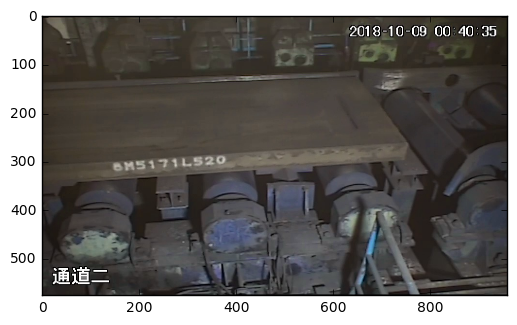

In [9]:
plt.imshow(images[0])

In [10]:
%time res = model.predict(images[0:1,:,:,:])

Wall time: 2.95 s


In [11]:
res1 = res[0]
res1[res1>0.9]= 1
res1[res1<=0.9]= 0
newres1 = []
for i in range(5):
    n = np.logical_and(res1[:,:,5],res1[:,:,i]) * 255
    newres1.append(n)
newres1.append(res1[:,:,5]*255)

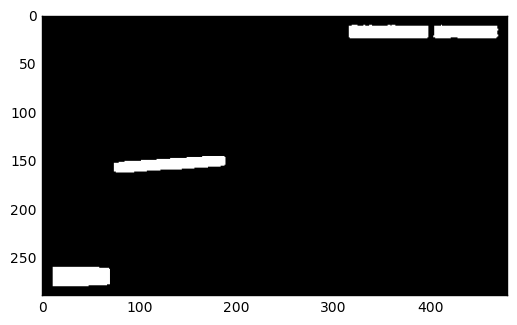

In [12]:
plt.imshow(newres1[5],cmap='gray')

In [13]:
_,regions = cv2.connectedComponents(newres1[0].astype('uint8'))

In [14]:
regions.shape

(288, 480)

In [16]:
from tool.utils import ufunc_4 , scale_expand_kernels ,fit_minarearectange,fit_boundingRect

Wall time: 1.38 s
Wall time: 11 ms
[array([[316,  23],
       [316,  10],
       [397,  10],
       [397,  23]], dtype=int64), array([[403,  23],
       [403,  10],
       [469,  10],
       [469,  23]], dtype=int64), array([[ 74, 162],
       [ 73, 150],
       [187, 143],
       [188, 155]], dtype=int64), array([[ 69, 278],
       [ 11, 278],
       [ 11, 259],
       [ 69, 259]], dtype=int64), array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int64)]


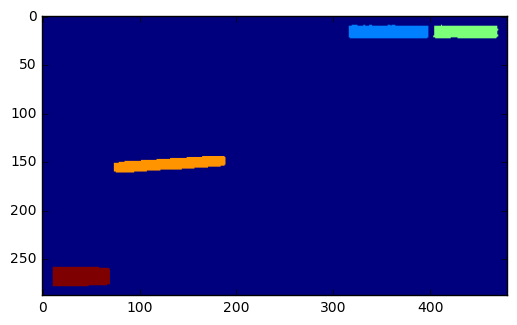

In [17]:
%time num_label,labelimage = scale_expand_kernels(newres1)
%time rects = fit_minarearectange(num_label,labelimage)
plt.imshow(labelimage)
print(rects)

In [18]:
labelimage[90,50]

0

In [19]:
imagetest = np.copy(images[0])
cv2.drawContours(imagetest,np.array(rects)*2,-1,(0,0,255),2)

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  4,   3,   0],
        ...,
        [  0,   1,   0],
        [  1,   2,   0],
        [  1,   2,   0]],

       [[  0,   0, 255],
        [ 44,  43,  39],
        [ 46,  43,  39],
        ...,
        [ 31,  32,  28],
        [ 33,  32,  28],
        [ 31,  33,  27]],

       [[ 49,  45,  40],
        [ 48,  45,  40],
        [ 48,  44,  39],
        ...,
        [ 35,  35,  29],
        [ 37,  34,  29],
        [ 35,  36,  27]],

       ...,

       [[ 42,  38,  37],
        [ 42,  38,  37],
        [ 41,  37,  36],
        ...,
        [ 81,  77,  76],
        [ 79,  75,  74],
        [ 78,  74,  73]],

       [[ 41,  37,  36],
        [ 41,  37,  36],
        [ 41,  37,  36],
        ...,
        [ 78,  74,  73],
        [ 75,  71,  70],
        [ 74,  70,  69]],

       [[ 41,  37,  36],
        [ 41,  37,  36],
        [ 40,  36,  35],
        ...,
        [  4,   0,   0],
        [  5,   1,   0],
        [  5,   1,   0]]

True

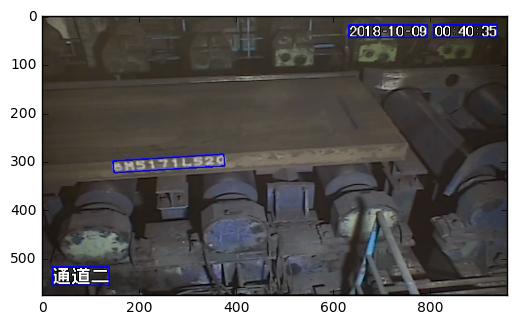

In [20]:
plt.imshow(imagetest)
cv2.imwrite('test2.jpg',imagetest)

In [39]:
h = r'E:\psenet-MTWI\document\mtwi_2018_task2_test\icpr_mtwi_task2\image_test\LB1gXi2JVXXXXXUXFXXXXXXXXXX.jpg'
images=cv2.imdecode(np.fromfile(h,dtype=np.uint8),-1) 
#images=cv2.cvtColor(images,cv2.COLOR_RGB2BGR)
cv2.imwrite(r'E:\tmp.jpg',images)

True